# [https://nickouellet.github.io](https://nickouellet.github.io)

# Nick Ouellet and Garrett Gilliom

# Investigating K-12 Academic Performance Based on District Data

## Project Goals
The team, **Nick Ouellet and Garrett Gilliom**, will be investigating data sets related to public school districts that measure student, faculty, and staff demographics, school district academic performance and finances, and more. So far, the team has come across two data sets for Louisiana school districts and many more for New Jersey school districts. Collectively, the data measures different variables and attributes of each state's school districts across the same year; the data is also well-populated and taken from each state's Department of Education, which is a reputable source.

The following tutorial will investigate the following questions:
- **What relationships exist between variables of financial, or otherwise demographic, data and the academic performance of school districts?** Examples:
    * How important a role does teacher compensation play in testing scores?
    * Is overall funding or spending of school district at all indicative of its academic performance?
    * Which areas are most effective at promoting successful test scores? For example, does allocating money to extracurriculars like sports aid or hinder testing scores?
- **Louisiana is consistently ranked as a low-performing state, education-wise. What differences exist between Louisiana and other high-performaing states that may highlight why Louisiana is ranked as such?**
- **Can data from one or a small group of states allow for the prediction of academic performance of other states' school districts?**

### Collaboration Plan
The team plans to meet once a week to work on this project to finalize our project vision, determine objectives, and assist each other where necessary. We will also be communicating thoroughly over text messages to keep each other updated with task progress and will be using Google Docs to keep an ongoing list of to-do items that’s accessible by each of us at all times. The team has also set up a shared Github repository to store, coordinate, and update our code.

In [1]:
import pandas as pd 
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import shapefile as shp
import geopandas as gpd
pd.set_option("display.max_rows", None, "display.max_columns", None)

## Louisiana Table 1: 
This first table is from the [U.S. Department of Education National Center for Education Statistics Common Code of Data (CCD)](https://nces.ed.gov/ccd/elsi/tableGenerator.aspx). Their website allows users to make specific queries to their database to get personalized data; the team opted to focus on 2016-2017 data on Louisiana public school districts, each of which is its own observation and row, and included nearly all variable measurements to be included for each district, including diversity levels within the district, pupil/teacher ratio, total revenue from different sources, and expenditures. The team chose this data set because it provides data on many points and variables that may be relevant upon further investigation; the years chosen were also found to be relatively well-populated and up-to-date.

In [2]:
info_df = pd.read_csv(r'LA_districts_2017.csv') #import financial/teacher/pupil info per district of LA
info_df.head()

,Agency Name,State Name [District] Latest available year,State Name [District] 2016-17,Agency Name [District] 2016-17,Agency Type [District] 2016-17,Total Students All Grades (Includes AE) [District] 2016-17,Male Students [District] 2016-17,Female Students [District] 2016-17,American Indian/Alaska Native - male [District] 2016-17,American Indian/Alaska Native - female [District] 2016-17,Asian or Asian/Pacific Islander - male [District] 2016-17,Asian or Asian/Pacific Islander - female [District] 2016-17,Hispanic - male [District] 2016-17,Hispanic - female [District] 2016-17,Black or African American - male [District] 2016-17,Black or African American - female [District] 2016-17,White - male [District] 2016-17,White - female [District] 2016-17,Nat. Hawaiian or Other Pacific Isl. - male [District] 2016-17,Nat. Hawaiian or Other Pacific Isl. - female [District] 2016-17,Two or More Races - male [District] 2016-17,Two or More Races - female [District] 2016-17,Full-Time Equivalent (FTE) Teachers [District] 2016-17,Pupil/Teacher Ratio [District] 2016-17,Kindergarten Teachers [District] 2016-17,Elementary Teachers [District] 2016-17,Secondary Teachers [District] 2016-17,Total Staff [District] 2016-17,Total General Revenue (TOTALREV) [District Finance] 2016-17,Total Revenue - Federal Sources (TFEDREV) [District Finance] 2016-17,Total Revenue - State Sources (TSTREV) [District Finance] 2016-17,Total Revenue - Local Sources (TLOCREV) [District Finance] 2016-17,Total Revenue (TOTALREV) per Pupil (V33) [District Finance] 2016-17,Instruction Expenditures - Total (E13) [District Finance] 2016-17,Salary - Instruction Expenditures (Z33) [District Finance] 2016-17
0,A.E. PHILLIPS LABORATORY SCHOOL,Louisiana,LOUISIANA,A.E. Phillips Laboratory School,8-Other education agencies,394,194,195,–,–,5,5,3,1,41,41,148,149,–,–,–,1,22.00,17.91,2.50,18.50,1.00,25.00,–,–,–,–,"=""0""",–,–
1,ABRAMSON SCI ACADEMY,LOUISIANA,LOUISIANA,RSD-Collegiate Academies,7-Independent Charter District,561,307,253,1,–,21,21,5,2,268,221,8,5,1,2,3,3,36.99,15.17,†,†,36.99,83.74,8252000,1397000,3605000,3250000,14709,3473000,2588000
2,ACADIA PARISH,Louisiana,LOUISIANA,Acadia Parish,1-Regular local school district that is NOT a ...,9839,5050,4787,9,9,9,5,149,115,1339,1212,3347,3233,–,–,198,214,548.94,17.92,39.00,322.36,163.58,1119.35,95051000,15149000,53342000,26560000,9661,54183000,35390000
3,ACADIANA RENAISSANCE CHARTER ACADEMY,LOUISIANA,LOUISIANA,Acadiana Renaissance Charter Academy,7-Independent Charter District,887,430,454,1,3,3,4,20,15,39,46,367,388,–,–,1,–,53.08,16.71,6.95,27.16,18.97,86.36,8941000,433000,3525000,4983000,10080,4328000,3089000
4,ADVANTAGE CHARTER ACADEMY,LOUISIANA,LOUISIANA,Advantage Charter Academy,7-Independent Charter District,553,279,267,–,1,–,–,8,6,268,253,7,10,–,–,–,–,34.30,16.12,5.27,23.03,6.00,67.63,6703000,753000,2952000,2998000,12121,2891000,1776000


This data table not only includes parish (equivalent to districts) information, but information about each school. Because we only wish to study parish data, we will drop the rest of the columns.

In [3]:
def check_parish(entry):
    if re.search(r'PARISH',entry) == None:
        return "not a parish"
    return entry

In [4]:
info_df['Agency Name'] = info_df['Agency Name'].apply(check_parish) #mark all entries that are no parishes
info_df = info_df[info_df["Agency Name"] != "not a parish"]
print(len(info_df)) #we know we have succedded because there are 64 entries and 64 parishes in LA

64


We are only studying Louisiana schools, so will will drop the columns that give us redundant data (namely 'State Name [District] Latest available year' and 'State Name [District] 2016-17'). We will also drop 'Agency Name [District]' column because we already are representing that info and 'Agency Type [District] 2016-17' because we know we are only dealing with districts.

In [5]:
info_df.drop(columns = ["State Name [District] Latest available year", "State Name [District] 2016-17", "Agency Name [District] 2016-17","Agency Type [District] 2016-17"], inplace = True)
info_df = info_df.reset_index(drop=True) #reset the numberical index to be 0-63 to accomidate for dropped rows


Now we will rename certain columns to remove excess wording.

In [6]:
info_df = info_df.rename(columns = { "Agency Name": "Parish",
                                     "Total Students All Grades (Includes AE) [District] 2016-17":"Total Students",
                                     'Male Students [District] 2016-17': "Male Students",
                                     'Female Students [District] 2016-17':"Female Students", 
                                     'American Indian/Alaska Native - male [District] 2016-17': 'American Indian/Alaska Native - Male',
                                     "American Indian/Alaska Native - female [District] 2016-17": "American Indian/Alaska Native - Female",
                                     'Asian or Asian/Pacific Islander - male [District] 2016-17':"Asian or Asian/Pacific Islander - Male",
                                     'Asian or Asian/Pacific Islander - female [District] 2016-17': "Asian or Asian/Pacific Islander - Female",
                                     "Total General Revenue (TOTALREV) [District Finance] 2016-17": "Total Revenue",
                                     "Total Revenue - Federal Sources (TFEDREV) [District Finance] 2016-17": "Federal Revenue", 
                                     "Total Revenue - State Sources (TSTREV) [District Finance] 2016-17": "State Revenue", 
                                     "Total Revenue - Local Sources (TLOCREV) [District Finance] 2016-17": "Local Revenue",
                                     "Total Revenue (TOTALREV) per Pupil (V33) [District Finance] 2016-17": "Revenue per Pupil", 
                                     "Instruction Expenditures - Total (E13) [District Finance] 2016-17": "Instruction Expendeture", 
                                     "Salary - Instruction Expenditures (Z33) [District Finance] 2016-17": "Salary Expendeture", 
                                     'Hispanic - male [District] 2016-17': "Hispanic - Male",
                                    'Hispanic - female [District] 2016-17':"Hispanic - Female",
                                    'Black or African American - male [District] 2016-17':"Black or African American - Male",
                                    'Black or African American - female [District] 2016-17':"Black or African American - Female",
                                    'White - male [District] 2016-17':"White - Male",
                                    'White - female [District] 2016-17':"White - Female",
                                    'Nat. Hawaiian or Other Pacific Isl. - male [District] 2016-17':"Nat. Hawaiian or Other Pacific Isl. - Male",
                                    'Nat. Hawaiian or Other Pacific Isl. - female [District] 2016-17':"Nat. Hawaiian or Other Pacific Isl. - Female",
                                    'Two or More Races - male [District] 2016-17':"Two or More Races - Male",
                                    'Two or More Races - female [District] 2016-17':"Two or More Races - Female",
                                    'Full-Time Equivalent (FTE) Teachers [District] 2016-17':"Full-Time Teachers",
                                    'Pupil/Teacher Ratio [District] 2016-17':"Pupil/Teacher Ratio",
                                    'Kindergarten Teachers [District] 2016-17':"Kindergarten Teachers",
                                    'Elementary Teachers [District] 2016-17':"Elementary Teachers",
                                    'Secondary Teachers [District] 2016-17':"Secondary Teachers",
                                    'Total Staff [District] 2016-17':"Total Staff"
                                     })

Now, we will remove the "PARISH" values from each row entry under the Parish column and also return the entries as lower case.

In [7]:
def remove_Parish(entry):
    return re.sub(r" PARISH", r"", entry)

def get_lower(entry):
    return entry.lower()

In [8]:
info_df['Parish'] = info_df['Parish'].apply(remove_Parish)
info_df['Parish'] = info_df['Parish'].apply(get_lower)

Let's now remove all missing data and replace it with NaN.

In [9]:
def replace_empty_with_NAN(entry):
    entry = str(entry)
    if re.search("–", entry) != None:
        return np.nan
    elif re.search('="0"',entry) != None:
        return np.nan
    elif re.search('="0.00"', entry) != None:
        return np.nan
    return entry


In [10]:
for col in info_df.columns:
    info_df[col] = info_df[col].apply(replace_empty_with_NAN)

Checking the dtypes, we find that the columns are not properly formatted so we make the appropriate changes. 

In [11]:
info_df.dtypes.head()

Parish                                  object
Total Students                          object
Male Students                           object
Female Students                         object
American Indian/Alaska Native - Male    object
dtype: object

In [12]:
lst_of_col = ["Total Students", "Male Students","Female Students", "American Indian/Alaska Native - Male", "American Indian/Alaska Native - Female","Asian or Asian/Pacific Islander - Male", "Asian or Asian/Pacific Islander - Female","Hispanic - Male", "Hispanic - Female",
"Black or African American - Male",
"Black or African American - Female",
"White - Male",
"White - Female",
"Nat. Hawaiian or Other Pacific Isl. - Male",
"Nat. Hawaiian or Other Pacific Isl. - Female",
"Two or More Races - Male",
"Two or More Races - Female", 
"Total Staff",
"Total Revenue",
"Federal Revenue",
"State Revenue",
"Local Revenue",
"Revenue per Pupil",
"Instruction Expendeture",
"Salary Expendeture",
"Full-Time Teachers",
"Pupil/Teacher Ratio",
"Kindergarten Teachers",
"Elementary Teachers",
"Secondary Teachers"]

for col in lst_of_col:
    info_df[col] = info_df[col].astype('float')

In [13]:
info_df.dtypes.head() #much better

Parish                                   object
Total Students                          float64
Male Students                           float64
Female Students                         float64
American Indian/Alaska Native - Male    float64
dtype: object

In [14]:
info_df.head() #a look at the final dataframe after data has been tidied

,Parish,Total Students,Male Students,Female Students,American Indian/Alaska Native - Male,American Indian/Alaska Native - Female,Asian or Asian/Pacific Islander - Male,Asian or Asian/Pacific Islander - Female,Hispanic - Male,Hispanic - Female,Black or African American - Male,Black or African American - Female,White - Male,White - Female,Nat. Hawaiian or Other Pacific Isl. - Male,Nat. Hawaiian or Other Pacific Isl. - Female,Two or More Races - Male,Two or More Races - Female,Full-Time Teachers,Pupil/Teacher Ratio,Kindergarten Teachers,Elementary Teachers,Secondary Teachers,Total Staff,Total Revenue,Federal Revenue,State Revenue,Local Revenue,Revenue per Pupil,Instruction Expendeture,Salary Expendeture
0,acadia,9839.0,5050.0,4787.0,9.0,9.0,9.0,5.0,149.0,115.0,1339.0,1212.0,3347.0,3233.0,NaN,NaN,198.0,214.0,548.94,17.92,39.00,322.36,163.58,1119.35,95051000.0,15149000.0,53342000.0,26560000.0,9661.0,54183000.0,35390000.0
1,allen,4279.0,2167.0,2112.0,29.0,19.0,22.0,18.0,33.0,30.0,438.0,436.0,1581.0,1545.0,2.0,1.0,62.0,63.0,321.63,13.30,22.50,187.11,93.52,623.56,48581000.0,4348000.0,29928000.0,14305000.0,11353.0,26659000.0,17209000.0
2,ascension,21942.0,11398.0,10544.0,32.0,32.0,157.0,114.0,857.0,775.0,3474.0,3232.0,6649.0,6136.0,15.0,17.0,214.0,238.0,1339.28,16.38,44.99,852.30,414.69,2603.89,308842000.0,47048000.0,98359000.0,163435000.0,14075.0,158570000.0,84263000.0
3,assumption,3589.0,1845.0,1742.0,4.0,5.0,8.0,8.0,85.0,81.0,796.0,724.0,931.0,903.0,NaN,NaN,22.0,22.0,214.98,16.69,11.05,118.38,65.01,506.84,42026000.0,5487000.0,22872000.0,13667000.0,11710.0,21872000.0,13509000.0
4,avoyelles,5534.0,2892.0,2641.0,33.0,23.0,18.0,13.0,22.0,31.0,1387.0,1251.0,1340.0,1243.0,1.0,NaN,91.0,81.0,271.80,20.36,20.91,120.59,117.30,614.02,54910000.0,8976000.0,33037000.0,12897000.0,9922.0,29270000.0,15720000.0


___

## Louisiana Table 2:
The second dataset comes from the [Louisiana Department of Education](https://www.louisianabelieves.com/resources/library/performance-scores) and includes data relating to measurements of student performance, including a “Letter Grade,” Assessment Index/Index ACT, strength of diploma, cohort graduation rate index, and progress points. The folloiwng data can be downloaded by clicking on the "2017 District Performance Scores" link under "District Performance Scores."

Each school district is, again, separated as their own observation, which marks school districts as the unit of observation across both this and the former dataset. Again, this dataset comes from a reputable source, being the Louisiana Department of Education; the data also recognizes that some of its measurements may not be too complete or are unreliable and marks values as such; however, nearly every cell is filled in, so little cleaning will need to be done otherwise. This dataset may provide insight into the following questions:
* What school districts perform best in Louisiana?
* What performance-related measurements correlate with each other?
* What are poorly performing districts struggling with?
* What might poorly performing districts attempt to focus on to improve?


In [15]:
grades_df = pd.read_csv(r'performance_summary.csv') #import grading of each district of LA
grades_df.head() #Livingston parish not reported due to flooding in '16-'17

,District,2017 Letter Grade,2017 Annual DPS,2016 Letter Grade,2016 Annual DPS,2017 Assessment Index\nGrades 3-8*,2017 Dropout Credit Accumulation Index*,2017 Assessment Index\nEnd-of-Course Exams*,2017 Assessment Index\nACT*,Strength of Diploma (Graduation Index) (2015-16 Cohort)*,Cohort Graduation Rate Index \n(Points Earned for Cohort Graduation Rate) \n(2015-16 Cohort)*,Cohort Graduation Rate (Actual Graduation Rate) (2015-16 Cohort)**,2017 Progress Points,2016 Assessment Index\nGrades 3-8*,2016 Dropout Credit Accumulation Index*,2016 Assessment Index\nEnd-of-Course Exams*,2016 Assessment Index\nACT*,Strength of Diploma (Graduation Index) (2014-15 Cohort)*,Cohort Graduation Rate Index \n(Points Earned for Cohort Graduation Rate) \n (2014-15 Cohort)*,Cohort Graduation Rate (Actual Graduation Rate) (2014-15 Cohort)**,2016 Progress Points,Unnamed: 21
0,Acadia Parish,B,90.0,B,97.3,78.8,137.4,70.5,90.6,93.4,122.6,86.3,3.3,81.6,139.8,69.6,87.2,89.8,120.2,85.1,10.0,NaN
1,Allen Parish,A,103.4,A,104.2,85.9,143.6,77.4,98.2,96.3,127.6,88.8,10.0,88.6,139.8,68.9,93.4,98.9,132.2,91.1,10.0,NaN
2,Ascension Parish,A,110.4,A,109.3,92.6,141.8,97.9,99.0,105.9,125.8,87.9,10.0,92.6,140.9,97.1,95.0,101.5,125.4,87.7,10.0,NaN
3,Assumption Parish,B,95.0,B,93.3,75.5,143.6,67.9,91.4,90.7,119.6,84.8,10.0,78.0,139.7,68.9,75.9,88.1,111,80.5,10.0,NaN
4,Avoyelles Parish,C,71.5,C,73.6,53.7,128.6,54.7,95.1,86.6,103.4,76.7,3.1,57.3,123,48.3,91.4,75.1,93.2,71.6,6.2,NaN


Rename 'District' column to 'Parish', and lower case all parish names as well as removing "Parish" from values.

In [16]:
def remove_parish(entry):
    return re.sub(r" parish", r"", entry)

grades_df = grades_df.rename(columns = {"District": "Parish"})
grades_df["Parish"] = grades_df["Parish"].apply(get_lower)
grades_df["Parish"] = grades_df["Parish"].apply(remove_parish) #important to run this command after the get_lower() command because get_parish is only looking for lower case 

We have too much information right now, let's drop some unnecessary columns to de-cluter the dataframe.

In [17]:
# Drop observstions in both tables that don't align and unnecessary columns
grades_df = grades_df.loc[:62]
grades_df = grades_df.drop(["Unnamed: 21"], axis=1)
grades_df = grades_df.drop(columns = ['2017 Annual DPS ',
       '2016 Letter Grade ', '2016 Annual DPS ',
       '2017 Assessment Index\nGrades 3-8*',
       '2017 Dropout Credit Accumulation Index*',
       '2017 Assessment Index\nEnd-of-Course Exams*','Strength of Diploma (Graduation Index) (2015-16 Cohort)*',
       '2017 Progress Points', '2016 Assessment Index\nGrades 3-8*',
       '2016 Dropout Credit Accumulation Index*',
       '2016 Assessment Index\nEnd-of-Course Exams*',
       '2016 Assessment Index\nACT*',
       'Strength of Diploma (Graduation Index) (2014-15 Cohort)*',
       ' Cohort Graduation Rate Index \n(Points Earned for Cohort Graduation Rate)  \n (2014-15 Cohort)*',
       ' Cohort Graduation Rate (Actual Graduation Rate) (2014-15 Cohort)**',
       '2016 Progress Points',' Cohort Graduation Rate Index \n(Points Earned for Cohort Graduation Rate)      \n(2015-16 Cohort)*'])
grades_df = grades_df.rename(columns={" Cohort Graduation Rate (Actual Graduation Rate) (2015-16 Cohort)**":"Graduation Rate", "2017 Letter Grade ": "2017 Letter Grade"})
info_df = info_df.drop(31).reset_index().drop(["index"], axis=1)

As of now, the ACT assesment index does not mean much. We will translate the ACT index score to an average score reflective of the actual ACT scores achieved by students. The scale is as follows ([from louisianabelieves.com](https://www.louisianabelieves.com/docs/default-source/district-support/using-the-school-performance-score-calculator.pdf)): <br/>

ACT Score -> ACT Index Score <br/>
0-17     ->    0.0 <br/>
18       ->    70.0 <br/>
19       ->    80.0 <br/> 
20       ->    90.0 <br/>
21       ->    100.0 <br/>
22       ->    103.4 <br/>
23       ->    106.8 <br/>
24       ->    110.2 <br/>


In [18]:
min_score, max_score = grades_df["2017 Assessment Index\nACT*"].min(),grades_df["2017 Assessment Index\nACT*"].max()
print("Lowest ACT index:",min_score)
print("Highest ACT index:", max_score)

Lowest ACT index: 53.4
Highest ACT index: 106.0


Since our highest score is a 106.0, we won't need to convert to a score higher than a 22 according to the table, and we will convert the lowest score to a 70.

In [19]:
def convert_to_raw_act(entry):
    if entry < 70:
        return 17
    elif entry < 80:
        return 18
    elif entry < 90:
        return 19
    elif entry < 100:
        return 20
    elif entry < 103.4:
        return 21
    else:
        return 22

In [20]:
grades_df["Raw ACT Score"] = grades_df["2017 Assessment Index\nACT*"].apply(convert_to_raw_act)
grades_df = grades_df.drop(columns=["2017 Assessment Index\nACT*"])

In [21]:
# Merge grades and info into one large dataframe, where each row is an observation of a district
la_df = grades_df.merge(info_df, on=["Parish"])

## The Final Louisiana Dataframe:

In [22]:
la_df.head()

,Parish,2017 Letter Grade,Graduation Rate,Raw ACT Score,Total Students,Male Students,Female Students,American Indian/Alaska Native - Male,American Indian/Alaska Native - Female,Asian or Asian/Pacific Islander - Male,Asian or Asian/Pacific Islander - Female,Hispanic - Male,Hispanic - Female,Black or African American - Male,Black or African American - Female,White - Male,White - Female,Nat. Hawaiian or Other Pacific Isl. - Male,Nat. Hawaiian or Other Pacific Isl. - Female,Two or More Races - Male,Two or More Races - Female,Full-Time Teachers,Pupil/Teacher Ratio,Kindergarten Teachers,Elementary Teachers,Secondary Teachers,Total Staff,Total Revenue,Federal Revenue,State Revenue,Local Revenue,Revenue per Pupil,Instruction Expendeture,Salary Expendeture
0,acadia,B,86.3,20,9839.0,5050.0,4787.0,9.0,9.0,9.0,5.0,149.0,115.0,1339.0,1212.0,3347.0,3233.0,NaN,NaN,198.0,214.0,548.94,17.92,39.00,322.36,163.58,1119.35,95051000.0,15149000.0,53342000.0,26560000.0,9661.0,54183000.0,35390000.0
1,allen,A,88.8,20,4279.0,2167.0,2112.0,29.0,19.0,22.0,18.0,33.0,30.0,438.0,436.0,1581.0,1545.0,2.0,1.0,62.0,63.0,321.63,13.30,22.50,187.11,93.52,623.56,48581000.0,4348000.0,29928000.0,14305000.0,11353.0,26659000.0,17209000.0
2,ascension,A,87.9,20,21942.0,11398.0,10544.0,32.0,32.0,157.0,114.0,857.0,775.0,3474.0,3232.0,6649.0,6136.0,15.0,17.0,214.0,238.0,1339.28,16.38,44.99,852.30,414.69,2603.89,308842000.0,47048000.0,98359000.0,163435000.0,14075.0,158570000.0,84263000.0
3,assumption,B,84.8,20,3589.0,1845.0,1742.0,4.0,5.0,8.0,8.0,85.0,81.0,796.0,724.0,931.0,903.0,NaN,NaN,22.0,22.0,214.98,16.69,11.05,118.38,65.01,506.84,42026000.0,5487000.0,22872000.0,13667000.0,11710.0,21872000.0,13509000.0
4,avoyelles,C,76.7,20,5534.0,2892.0,2641.0,33.0,23.0,18.0,13.0,22.0,31.0,1387.0,1251.0,1340.0,1243.0,1.0,NaN,91.0,81.0,271.80,20.36,20.91,120.59,117.30,614.02,54910000.0,8976000.0,33037000.0,12897000.0,9922.0,29270000.0,15720000.0


## Exploration of LA data:

<AxesSubplot:xlabel='Revenue per Pupil', ylabel='2017 Letter Grade'>

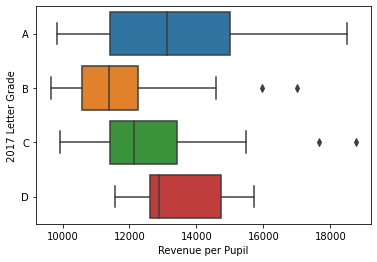

In [23]:
sns.boxplot(x=la_df["Revenue per Pupil"],y=la_df["2017 Letter Grade"],order=["A","B","C","D"])

Our intuition would tell us that the higher ranked schools would have a higher Revenue per Pupil, but upon further inspection we don't always see this to be true. While the median is highest in the highest ranked schools, we can see that the "B" rank schools actually have the lowest Revenue per Pupil ratio. Lets look at data that would indicate a sucessful education, namely ACT score.

In [24]:
act_table = pd.crosstab(la_df["2017 Letter Grade"], la_df["Raw ACT Score"])
act_table

Raw ACT Score,17,18,19,20,21,22
2017 Letter Grade,,,,,,
A,0,0,1,10,1,3
B,0,2,6,12,2,1
C,3,3,7,3,0,1
D,4,3,0,0,0,0


It seems like the highely rated schools produce a higher ACT score in general. Lets plot this information, along with graduation rates and total revenues.

<AxesSubplot:xlabel='Graduation Rate', ylabel='Total Revenue'>

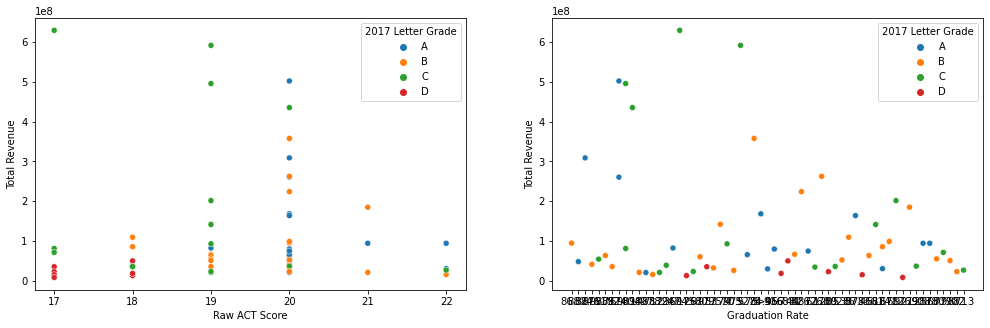

In [25]:
total_rev_fig, total_rev_ax = plt.subplots(1,2,figsize = (17,5))

sns.scatterplot(y=la_df["Total Revenue"], x = la_df["Raw ACT Score"], data=la_df, hue=la_df["2017 Letter Grade"],hue_order=["A","B","C","D"],ax=total_rev_ax[0])
sns.scatterplot(y=la_df["Total Revenue"], x = la_df["Graduation Rate"], data=la_df, hue=la_df["2017 Letter Grade"],hue_order=["A","B","C","D"],ax = total_rev_ax[1])

These tables shows that a higher revenue does not always mean a better education. Clearly we have an example of a school with a C rank, low graduation rate, and low ACT score having the highest revenue in the entire state. Let us now plot the average ACT score and graduation rate against the revenue per pupil so that schools with large populations are not skewed.


<AxesSubplot:xlabel='Graduation Rate', ylabel='Revenue per Pupil'>

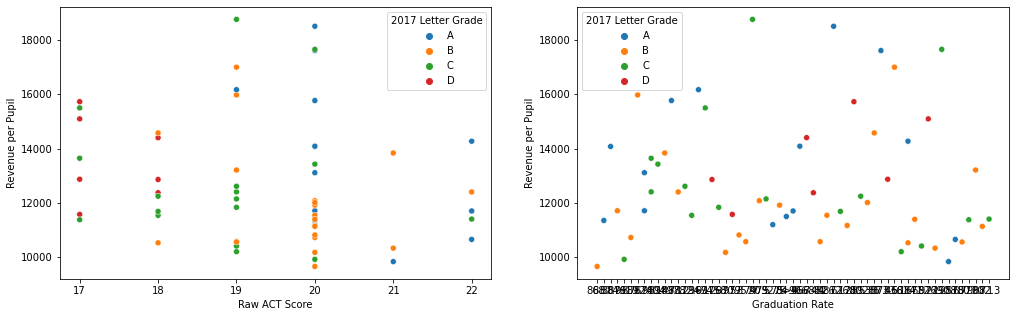

In [26]:
rppfig,rppax = plt.subplots(1,2,figsize = (17,5))

sns.scatterplot(y=la_df["Revenue per Pupil"], x = la_df["Raw ACT Score"], data=la_df, hue=la_df["2017 Letter Grade"],hue_order=["A","B","C","D"], ax = rppax[0])
sns.scatterplot(y=la_df["Revenue per Pupil"], x = la_df["Graduation Rate"], data=la_df, hue=la_df["2017 Letter Grade"],hue_order=["A","B","C","D"],ax=rppax[1])

We cannot say much in terms of Revenue per Pupil, ACT, and Graduation Rate as they do not seem to correlate much at all. Let us now explore a more successful school system: The New Jersey School System.

___
## New Jersey: a Basis for Comparison
Let's take a look at another state's education data, namely New Jersey, which is a consistently ranked high by [reputable sources](https://www.nj.gov/governor/news/news/562021/20210309a.shtml) for their K-12 public education system. By investigating the relative differences between New Jersey and Louisiana's education systems, explanations for why Louisiana underperforms may be found. </br> </br>
Similar to the Louisiana data sets, we'll look into district demographics, financial information, and performance statistics to examine the attributes across school districts.

### New Jersey Budgets
2016-2017 financial data for New Jersey public schools will be used for analysis and taken from the website of New Jersey's Department of Education. The data sets, along with a layout file, can be found [here](https://www.nj.gov/education/finance/fp/ufb/2016/download.shtml).

#### Revenues
Let's first take a look at revenues, or how much money each school district in New Jersey and Louisiana are bringing in from the local, state, and federal levels. </br>
We would expect that, on average, New Jersey public schools have more funding, as its schools are consistently rated highly compared to other states'. </br>
We will first clean the data, as the revenue for each district is split amoungst many rows.

In [27]:
nj_rev_df = pd.read_csv(r'nj_rev.csv')
nj_rev_df = nj_rev_df[pd.notna(nj_rev_df["ACCOUNT"])] # Remove subtotal observations
nj_rev_df = nj_rev_df.drop(columns=["COUNTY_ID", "CONAME", "DISTRICT_ID", "LINE_NO", "ACCOUNT", "AMOUNT_2", "AMOUNT_3"])
nj_rev_df = nj_rev_df.rename(columns={"AMOUNT_1": "Revenue"})

In [28]:
# Group revenues together under one "Revenue" attribute
nj_rev_cube = nj_rev_df.pivot_table(
    index="DISTNAME",
    values="Revenue", aggfunc=np.sum)
nj_rev_cube.head()


,Revenue
DISTNAME,
ABSECON CITY,13397662.0
ALEXANDRIA TWP,10193006.0
ALLAMUCHY TWP,9709362.0
ALLENDALE BORO,16131608.0
ALLENHURST,255179.0


Much more neat and meaningful. </br>
From this, we can determine both the total revenue of New Jersey public schools and average revenue across its school distrcits. Let's look at these numbers next to the saem statistics of Louisiana and its school districts to see how they line up.

In [29]:
nj_rev_sum = nj_rev_cube["Revenue"].sum()
print("New Jersey total revenue:", nj_rev_sum)
nj_rev_count = nj_rev_cube["Revenue"].count()
print("New Jersey school district count:", nj_rev_count)
nj_rev_mean = nj_rev_cube["Revenue"].mean()
print("New Jersey average total revenue:", nj_rev_mean)
print()
la_rev_sum = la_df["Total Revenue"].sum()
print("Louisiana total revenue:", la_rev_sum)
la_rev_count = la_df["Total Revenue"].count()
print("Louisiana school district count:", la_rev_count)
la_rev_mean = la_df["Total Revenue"].mean()
print("Louisiana average total revenue:", la_rev_mean)

New Jersey total revenue: 26077730552.0
New Jersey school district count: 582
New Jersey average total revenue: 44807097.16838488

Louisiana total revenue: 7387585000.0
Louisiana school district count: 62
Louisiana average total revenue: 119154596.77419356


From this, we can see that although New Jersey receives nearly 4x more revenue in total than Louisiana does,  Louisiana school districts receive more funding, on average, than those in New Jersey. It's clear that this is the case because New Jersey has far more school distrits than Louisiana does – nearly 10x as many.</br></br>
When we view histograms of each, we see that both states have a few outliers receiving a lot of funding, with most receiving a much lower portion:

<AxesSubplot:title={'center':'LA'}, ylabel='Frequency'>

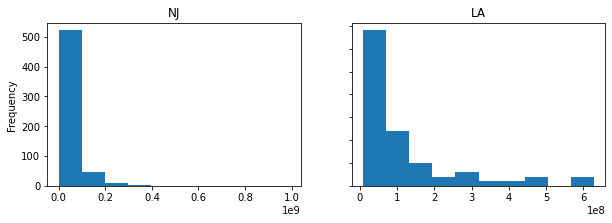

In [30]:
# https://stackoverflow.com/questions/45069828/how-to-plot-2-histograms-side-by-side
fig, axes = plt.subplots(1,2,figsize=(10,3))

axes[0].set_title('NJ')
axes[1].set_title('LA')

nj_rev_cube["Revenue"].plot.hist(ax=axes[0],sharey=True)
la_df["Total Revenue"].plot.hist(ax=axes[1], sharey=True)

By examining these distributions as a box plot, we can get a better sense of how the data is distributed:

<AxesSubplot:>

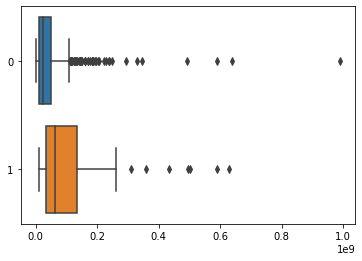

In [31]:
sns.boxplot(data=[nj_rev_cube["Revenue"].rename("NJ"), la_df["Total Revenue"].rename("LA")], orient="h")

From this, we can tell that Louisiana's funding is spread out better than New Jersey's, as New Jersey's box plot reveals many outliers. Let's look at revenue per pupil, next:

In [32]:
# Create enrollment dataframe
nj_enroll_df = pd.read_csv(r'nj_enroll.csv')
nj_enroll_df = nj_enroll_df[nj_enroll_df["ENROLL_CAT"] == "Onroll (Full)"] # Get just full amounts
nj_enroll_df.reset_index(inplace=True)
nj_enroll_df.drop(columns=["index", "COUNTY_ID", "CONAME", "DISTRICT_ID", "ENROLL_LINE_NO", "ENROLL_CAT", "AMOUNT_2", "AMOUNT_3"], inplace=True)
nj_enroll_df = nj_enroll_df.rename(columns={"AMOUNT_1":"Enrollment"})
nj_enroll_df.head()

,DISTNAME,Enrollment
0,ABSECON CITY,804.0
1,ATLANTIC CITY,6630.0
2,ATLANTIC CO VOCATIONAL,1226.0
3,BRIGANTINE CITY,635.0
4,BUENA REGIONAL,1604.0


In [33]:
# Create revenue/pupil column
nj_enroll_rev = nj_rev_cube.merge(nj_enroll_df, on=["DISTNAME"], suffixes=("rev", "enroll"))
nj_enroll_rev = nj_enroll_rev[nj_enroll_rev["Enrollment"] != 0]
nj_enroll_rev["rev/pupil"] = nj_enroll_rev["Revenue"] / nj_enroll_rev["Enrollment"]

In [34]:
print("NJ rev/pupil: ",nj_enroll_rev["rev/pupil"].mean())
print("LA rev/pupil:",la_df["Revenue per Pupil"].mean())

NJ rev/pupil:  79844.84968801291
LA rev/pupil: 12694.709677419354


Here we see that New Jersey spends far more money per pupil than Louisiana does – about 6.5x more. To better view this distribution, let's perform a log transform:

[Text(0.5, 0, '$ log(Revenue/Pupil)'),
 Text(0, 0.5, 'School'),
 Text(0.5, 1.0, 'NJ & LA Revenue/Pupil')]

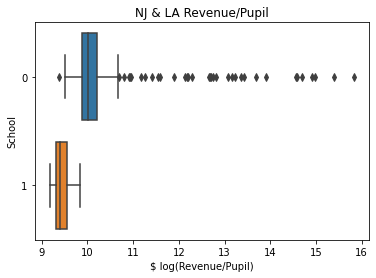

In [35]:
# Transform rev/pupil attribute
nj_enroll_rev["log(rev/pupil)"] = np.log(nj_enroll_rev["rev/pupil"])
la_df["log(Revenue per Pupil)"] = np.log(la_df["Revenue per Pupil"])
nj_log = nj_enroll_rev["log(rev/pupil)"].rename("NJ")
la_log = la_df["log(Revenue per Pupil)"].rename("LA")
sns.boxplot(data=[nj_log, la_log], orient="h").set(
    xlabel='$ log(Revenue/Pupil)', 
    ylabel='School',
    title="NJ & LA Revenue/Pupil"
)

From the above, we can see that the average rate of revenue per pupil is much higher for New Jersey school districts than for Louisiana school districts. The two metrics we've looked at, average total revenue and average total revenue per pupil, indicate opposing results. Let's incorporate a metric of academic performance or success, such as graduation rate, to determine whether either of these correllate with academic performance.

#### Revenue and Graduation Rate
New Jersey Enrollment data, as published by New Jersey's Department of Education, can be found [here](https://www.nj.gov/education/schoolperformance/grad/ACGR.shtml) under "2016 Adjusted Cohort 4 year Graduation rates (Excel)"

In [36]:
# Load in New Jersey Graduation data, convert to proper dtypes
nj_grad_df = pd.read_csv(r'nj_grad.csv')
nj_grad_all = nj_grad_df[nj_grad_df["SUBGROUP"] == "Districtwide"]
nj_grad_all.reset_index(inplace=True)
nj_grad_all = nj_grad_all.drop(columns=["index", "COUNTY_ID", "COUNTY_NAME", "DISTRICT_ID", "SCHOOL_CODE", "SCHOOL_NAME", "SUBGROUP", "Unnamed: 10"])

grad_nums = pd.to_numeric(nj_grad_all["FOUR_YR_GRAD_RATE"], errors="coerce", downcast="integer")
grad_df = pd.DataFrame(grad_nums)
nj_grad_all.pop("FOUR_YR_GRAD_RATE")
nj_grad_all = nj_grad_all.join(grad_df)

grad_nums = pd.to_numeric(nj_grad_all["FOUR_YR_ADJ_COHORT_COUNT"], errors="coerce", downcast="integer")
grad_df = pd.DataFrame(grad_nums)
nj_grad_all.pop("FOUR_YR_ADJ_COHORT_COUNT")
nj_grad_all = nj_grad_all.join(grad_df)

grad_nums = pd.to_numeric(nj_grad_all["GRADUATED_COUNT"], errors="coerce", downcast="integer")
grad_df = pd.DataFrame(grad_nums)
nj_grad_all.pop("GRADUATED_COUNT")
nj_grad_all = nj_grad_all.join(grad_df)

grad_nums = pd.to_numeric(la_df["Graduation Rate"], errors="coerce", downcast="integer")
grad_df = pd.DataFrame(grad_nums)
la_df.pop("Graduation Rate")
la_df = la_df.join(grad_df)


In [37]:
print("New Jersey average graduation rate:", nj_grad_all["FOUR_YR_GRAD_RATE"].mean())
print("Louisiana average graduation rate:", la_df["Graduation Rate"].mean())

New Jersey average graduation rate: 91.09950657894736
Louisiana average graduation rate: 81.5016393442623


We can see that the average 4 year graduation rate for New Jersey school districts is about 10% higher than that of Louisiana school districts. We'll create scatter plots to test whether a correlation between graduation rate and revenue statistics exists for both New Jersey and Louisiana schools.

In [38]:
nj_combo = nj_grad_all.merge(nj_enroll_rev, left_on="DISTRICT_NAME", right_on="DISTNAME", how="inner")
nj_combo = nj_combo.rename(columns={"DISTRICT_NAME":"District",
                         "FOUR_YR_GRAD_RATE": "Graduation Rate",
                         "rev/pupil": "Revenue per Pupil",
                         "Revenue": "Total Revenue" })

From these two tables, we'll be able to plot points based on graduation rates and total revenue, enrollment, and revenue per pupil. To get a better sense of the distribution, we'll be limiting the New Jersey data set based on total revenue, as we've seen that a few isolated outliers exist that makes it difficult to differentiate between the rest of the points.

<AxesSubplot:title={'center':'New Jersey Data'}, xlabel='Total Revenue', ylabel='Graduation Rate'>

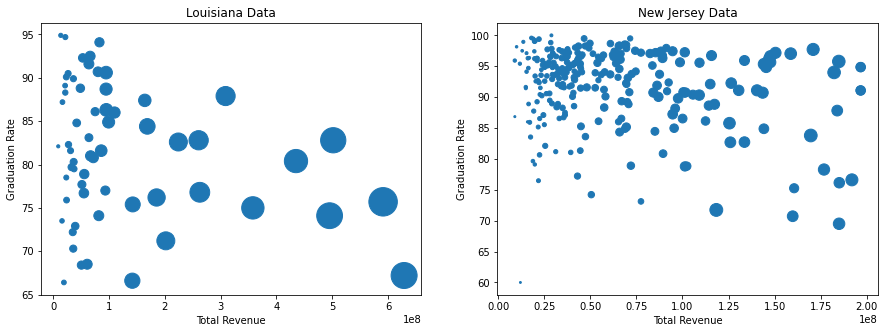

In [39]:
def adjustSize(size):
    return (size**1/600)*10


sfig,sax = plt.subplots(1,2,figsize = (15,5))
# Calculate sizes of plot points based on enrollment size, filtered by total revenue to remove outliers
nj_sizes = nj_combo[nj_combo["Total Revenue"] < 200000000]["Enrollment"].map(adjustSize)
la_sizes = la_df["Total Students"].map(adjustSize)

la_df.plot.scatter(x="Total Revenue", y="Graduation Rate", s=la_sizes, title="Louisiana Data",ax=sax[0])
nj_combo[nj_combo["Total Revenue"] < 200000000].plot.scatter(x="Total Revenue", y="Graduation Rate", s=nj_sizes,title="New Jersey Data",ax=sax[1])

From the above, we can see that not much of a correlation exists between revenue and 4-year graduation rates within school districts within either state. The size of each point corresponds to the number of enrolled students within each school, which was added for greater context when looking at the distribution of school districts.  </br> </br>
Let's next test revenue per pupil:

<AxesSubplot:title={'center':'New Jersey Data'}, xlabel='Revenue per Pupil', ylabel='Graduation Rate'>

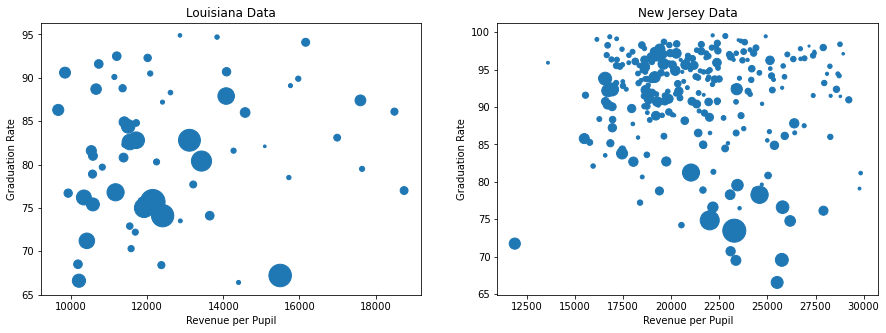

In [40]:
def adjustSize(size):
    return (size**1/800)*10

dfig,dax = plt.subplots(1,2,figsize = (15,5))

# Calculate sizes of plot points based on enrollment size, filtered revenue per pupil to remove outliers
nj_sizes = nj_combo[nj_combo["Revenue per Pupil"] < 30000]["Enrollment"].map(adjustSize)
la_sizes = la_df["Total Students"].map(adjustSize)

la_df.plot.scatter(x="Revenue per Pupil", y="Graduation Rate", s=la_sizes,title="Louisiana Data",ax = dax[0])
nj_combo[nj_combo["Revenue per Pupil"] < 30000].plot.scatter(x="Revenue per Pupil", y="Graduation Rate", s=nj_sizes, title="New Jersey Data",ax=dax[1])

These plots, too, produce little to no evidence of a correlation between graduation rates and revenues per pupil. Similar to before, the size of each point corresponds to the size of that school district's student population.

### Appropriations

So far, the team has found no relevant relationship between funding and academic perforamnce of school districts. Next, the team will investigate whether appropriations and spending, rather than funding, has any sort of relationship with academic performance. Instruction materials and resources, teacher salaries, and other forms of education expenditures will be looked into.

In [41]:
# Read in appropriations DataFrame
nj_approp_df = pd.read_csv(r'nj_approp.csv')
nj_approp_df[20:30]

,county_id,county_name,district_id,district_name,line_no,account,line_desc,amount_1,amount_2,amount_3
20,1,Atlantic,10,Absecon City,47200,'11-000-251-XX,Total Undistributed Expenditures-Central Services,249715.0,322436.0,314885.0
21,1,Atlantic,10,Absecon City,47620,'11-000-252-XX,Total Undistributed Expenditures-Administrativ...,47683.0,28193.0,43749.0
22,1,Atlantic,10,Absecon City,51120,'11-000-26X-XX,Total Undistributed Expenditures-Operation and...,859261.0,1001516.0,1150554.0
23,1,Atlantic,10,Absecon City,52480,'11-000-270-XX,Total Undistributed Expenditures-Student Trans...,539058.0,613145.0,529685.0
24,1,Atlantic,10,Absecon City,71260,'11-XXX-XXX-2X,Total Personal Services-Employee Benefits,2594225.0,2966577.0,3010525.0
25,1,Atlantic,10,Absecon City,72140,',Total Undistributed Expenditures,8452904.0,9460180.0,9672511.0
26,1,Atlantic,10,Absecon City,72180,'10-606,Interest Earned on Maintenance Reserve,0.0,10.0,10.0
27,1,Atlantic,10,Absecon City,72260,',Total General Current Expense,14203334.0,15580351.0,16090335.0
28,1,Atlantic,10,Absecon City,75880,'12-XXX-XXX-73,Total Equipment,78291.0,78782.0,109582.0
29,1,Atlantic,10,Absecon City,76260,'12-000-400-XX,Total Facilities Acquisition and Construction ...,32553.0,40742.0,730242.0


By looking at this data closely, it can be seen that a few observations exist without an account. These can be attributed to subtotals that should not be considered a part of the overall summation of monies. Let's filter our data to only work with observations with an actual account number related to each expense.

In [42]:
# Drop observations with no account, drop irrelevant columns, rename relevant appropriations column
nj_approp = nj_approp_df[nj_approp_df["account"] != "'"]
nj_approp = nj_approp.drop(columns=["county_id", "county_name", "district_id",
                                                  "line_no", "account", "amount_2", "amount_3"])
nj_approp = nj_approp.rename(columns={"amount_1": "Appropriations"})

In [43]:
# Sum appropriations values within each school district
nj_app_cube = nj_approp.pivot_table(
    index="district_name",
    values="Appropriations", aggfunc=np.sum)
nj_approp_totals = nj_app_cube.reset_index()
nj_approp_totals.head()

,district_name,Appropriations
0,Absecon City,19136368.0
1,Alexandria Twp,10511461.0
2,Allamuchy Twp,11470108.0
3,Allendale Boro,17378121.0
4,Allenhurst,322170.0


In [44]:
def make_uppercase(district):
    return district.upper()

In [45]:
nj_approp_totals['district_name'] = nj_approp_totals['district_name'].apply(make_uppercase)
nj_approp_totals = nj_approp_totals.sort_values(by="district_name")

In [46]:
nj_finances = nj_combo.merge(nj_approp_totals, left_on="DISTNAME", right_on="district_name", how="inner")
nj_finances = nj_finances.drop(columns=["district_name", "DISTNAME"])

In [47]:
la_df["Total Expendeture"] = la_df["Instruction Expendeture"] + la_df["Salary Expendeture"]

At this point, we've successfully loaded in and processed total appropriations numbers for the New Jersey School districts that had available data. Next, let's take a look at how this feature compares across the LA and NJ school districts.

In [48]:
nj_app_sum = nj_approp_totals["Appropriations"].sum()
print("New Jersey total appropriations:", nj_app_sum)
nj_app_count = nj_approp_totals["Appropriations"].count()
print("New Jersey school district count:", nj_app_count)
nj_app_mean = nj_approp_totals["Appropriations"].mean()
print("New Jersey average total appropriations:", nj_app_mean)
print()
la_app_sum = la_df["Total Expendeture"].sum()
print("Louisiana total appropriations:", la_app_sum)
la_app_count = la_df["Total Expendeture"].count()
print("Louisiana school district count:", la_app_count)
la_app_mean = la_df["Total Expendeture"].mean()
print("Louisiana average total appropriations:", la_app_mean)
print()
print("NJ/LA ratio for total appropriations", nj_app_sum/la_app_sum)
print("NJ/LA ratio for average total appropriations", nj_app_mean/la_app_mean)

New Jersey total appropriations: 30940087666.0
New Jersey school district count: 581
New Jersey average total appropriations: 53253162.9363167

Louisiana total appropriations: 6028606000.0
Louisiana school district count: 62
Louisiana average total appropriations: 97235580.64516129

NJ/LA ratio for total appropriations 5.132212598733439
NJ/LA ratio for average total appropriations 0.5476715681953067


From this data, we can see that NJ spends much more money in total, which makes sense considering how many more school districts it has. However, what's interesting is that LA school districts spend, on average, about twice as much as NJ school districts do. This reflects what we found earlier: that LA school districts bring in about 3 times more revenue per school district, on average, than those on NJ. These changes between the statistics are likely a result of the presence of massive outliers within the New Jersey school districts, as seen in the scatter plots throughout this analysis.
<br><br>
To explore further, let's investigate appropriations and revenue at the same time by computing their difference for each school district; this will be represented by a new "Monetary Difference" value. We'll be working with a slightly smaller data set for NJ, as not every school district could be accounted for during data work and processing.

In [49]:
nj_finances["Monetary Difference"] = nj_finances["Total Revenue"] - nj_finances["Appropriations"]
la_df["Monetary Difference"] = la_df["Total Revenue"] - la_df["Total Expendeture"]

First, let's use a boxplot to get a sense of how this new value is distributed across each state. A positive value would indicate that more money is being brought in than being spent while a negative value means the reverse, where more money is being spent by the school district than is being brought in (a.k.a. going over budget).

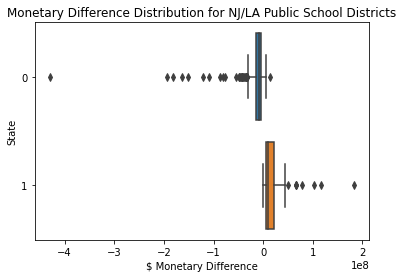

In [50]:
box = sns.boxplot(data=[nj_finances["Monetary Difference"], la_df["Monetary Difference"]], orient="h").set(
    xlabel='$ Monetary Difference', 
    ylabel='State',
    title="Monetary Difference Distribution for NJ/LA Public School Districts"
)

In New Jersey, it appears that most school districts are over-budget with a good portion being outliers that are __well__ over-budget. In Louisiana, on the other hand, the reverse is true: Most schools are just a bit under-budget with a few leaving lots of room to spare in terms of how much money they could spend.
<br><br>
Next, let's look at the relationship, if any, between graduation rate and appropriations for each state. To do so, we'll plot each variable combination on a scatter plot, similar to our methodology for investigating revenue and graduation rate:

<AxesSubplot:title={'center':'New Jersey Data'}, xlabel='Appropriations', ylabel='Graduation Rate'>

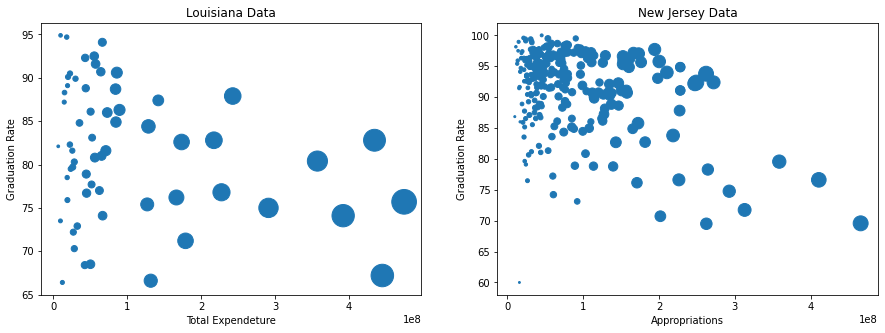

In [51]:
def adjustSize(size):
    return (size**1/600)*10

afig,aax = plt.subplots(1,2,figsize = (15,5))
# Calculate sizes of plot points, based on total revenue
nj_app_sizes = nj_finances[nj_finances["Appropriations"] < .6*1e9]["Enrollment"].map(adjustSize)

la_df.plot.scatter(x="Total Expendeture", y="Graduation Rate", s=la_sizes, title="Louisiana Data",ax = aax[0])
nj_finances[nj_finances["Appropriations"] < .6*1e9].plot.scatter(x="Appropriations", y="Graduation Rate", s=nj_app_sizes, title="New Jersey Data",ax=aax[1])


Before the investigation, the team expected to find evidence for a positive correlation between appropriations and graduation rate; it would make sense that the school districts that spend the most money on learning supplies and resources would garner the best performance metrics. However, from these plots, little evidence exists to support a strong argument for this relationship between the two variables. In fact, they appear to be negatively correlated, if anything, which is contradictory to what the team expected and similar to the results of the revenue vs. graduation rate plots.
<br> <br>
Finally, we'll look into whether a relationship exists between monetary difference, or how much a school district goes over/under budget, and graduation rate:

<AxesSubplot:title={'center':'New Jersey Data'}, xlabel='Monetary Difference', ylabel='Graduation Rate'>

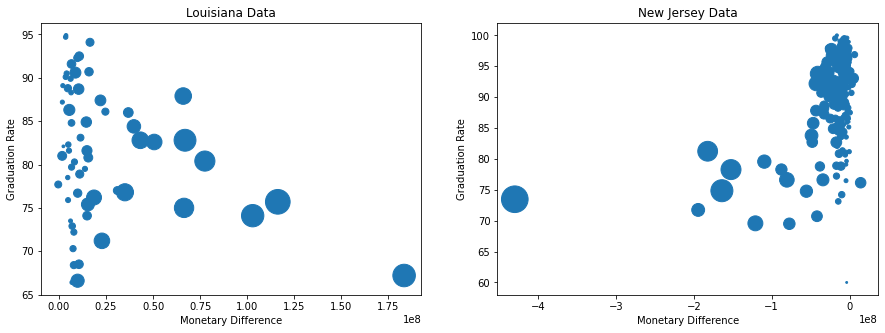

In [52]:
def adjustSize(size):
    return (size**1/600)*10

nj_diff = nj_finances["Monetary Difference"]


whisker = (nj_diff.quantile(.75)-nj_diff.quantile(.25)) * 1.5

yfig, yax = plt.subplots(1,2,figsize = (15,5))
# Calculate sizes of plot points, based on enrollment size

nj_app_sizes = nj_finances["Enrollment"].map(adjustSize)

la_df.plot.scatter(x="Monetary Difference", y="Graduation Rate", s=la_sizes, title="Louisiana Data",ax=yax[0])

nj_finances.plot.scatter(x="Monetary Difference", y="Graduation Rate", s=nj_app_sizes, title="New Jersey Data",ax=yax[1])


A few observations can be made from the plots above. First, in both plots, the vast majority of school districts are huddled around the 0 value for monetary difference, which makes sense considering school districts likely aim to be on-par with their budget year after year. Those aforementioned districts also feature a variety of graduation rates, from a couple in the 70% range to nearly 95-100%. As the monetary values grow further from that center point, though, the graduation rate tends to move downward in both plots, albeit in different directions.
<br>
it can be argued that this distribution of the data makes sense in both cases...

## MODEL

In [53]:
def avoid_nan(x):
    if pd.isna(x) == False:
        return float(x)
    return x

def tofloat(x):
    return float(x[:-2])

In [54]:
nj_student_ratio = pd.read_csv(r'StudentToStaffRatio.csv')
nj_student_ratio = nj_student_ratio[:-1] #drop last row because bad data
nj_student_ratio["TeacherRatio"] = nj_student_ratio["TeacherRatio"].apply(tofloat)
nj_district_code_translate = pd.read_csv(r'DistrictHeader.csv')
nj_district_code_translate.columns
nj_student_ratio["DistrictCode"] = nj_student_ratio["DistrictCode"].apply(avoid_nan)
nj_student_ratio = nj_student_ratio.merge(nj_district_code_translate,on= "DistrictCode",how="outer")
nj_student_ratio.head()
nj_student_ratio = nj_student_ratio.drop(columns = [
    "CountyCode",
    "DistrictCode",
    "AdministratorsRatio",
    "LibrarianMediaSpecialistsRatioDistrict",
    "NursesRatioDistrict",
    "CounselorsRatioDistrict",
    "ChildStudyTeamRatioDistrict",
    "COUNTY_CODE",
    "COUNTY_NAME",
    "GRADESPAN"
])

In [55]:
nj_student_ratio.rename(columns={"DISTRICT_NAME":"District"}, inplace=True)
nj_finances = nj_finances.merge(nj_student_ratio, on="District",how="inner")

In [56]:
nj_finances = nj_finances.dropna()

In [57]:
from sklearn.neighbors import KNeighborsRegressor
import math
features = [
            "Appropriations",
            "Total Revenue",
            "Enrollment",
            "TeacherRatio"            
            ]

X_train = pd.get_dummies(nj_finances[features])

X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train_sc = (X_train - X_train_mean) / X_train_std

y_train = nj_finances["Graduation Rate"]

k = math.ceil(math.sqrt(len(nj_combo))) #accepted value of k is sqrt(N) where N is number of training points.
model = KNeighborsRegressor(n_neighbors=k)


pred_dict = {}
for i,row in la_df.iterrows():
    x_new = pd.Series(index=X_train.columns, dtype=float)
    x_new["Appropriations"] = row["Total Expendeture"]
    x_new["Total Revenue"] = row["Total Revenue"]
    x_new["Enrollment"] = row["Total Students"]
    x_new["TeacherRatio"] = row["Pupil/Teacher Ratio"]
    # ...
    x_new.fillna(0, inplace=True)
    x_new_sc = (x_new - X_train_mean) / X_train_std
    model.fit(X_train_sc, y_train)
    
    X_new_sc = x_new_sc.to_frame().T
    output = model.predict(X_new_sc)
    pred_dict[row["Parish"]] = output[0]

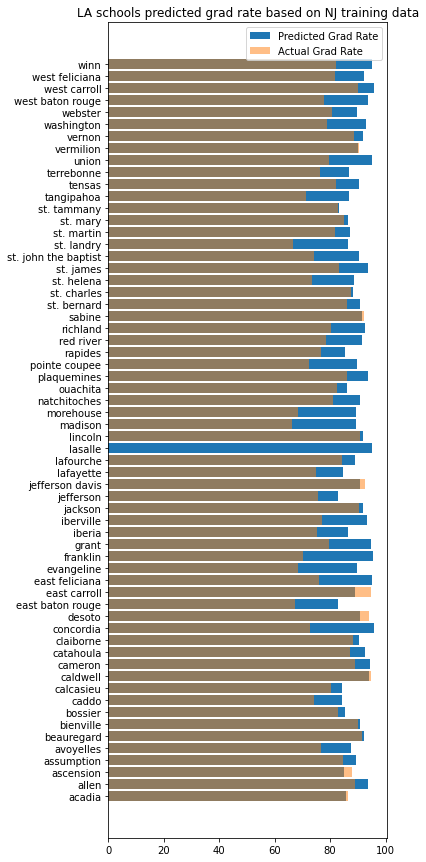

In [58]:
pred_lst = pred_dict.items()

pred_x,pred_y = zip(*pred_lst)

plt.figure(figsize=(5,15))
plt.barh(pred_x,pred_y, label="Predicted Grad Rate")
plt.barh(la_df["Parish"], la_df["Graduation Rate"],alpha=.5, label="Actual Grad Rate")
plt.legend()
plt.title("LA schools predicted grad rate based on NJ training data")
plt.show()

Now that we know that these factors are not all that affects graduation rates, it raises the question which factors do? Let us plot parish/districts along with thier graduation rates to see if there are any paterns that emerge.

In [59]:
la_shp = "la_coords/cb_2017_22_unsd_500k.shp" #read in shp data
la_coords_df = gpd.read_file(la_shp)

nj_shp = "nj_coords/School_Districts_-_Unified_for_New_Jersey.shp"
nj_coords_df = gpd.read_file(nj_shp)

In [60]:
nj_coords_df.head()

,OBJECTID,NJDOE_ID_U,DIST_NAME,UNSDLEA,SD_TYPE,GEOID,SHAPE_Leng,SHAPE_Area,geometry
0,1,31-0900,Clifton Public School District,03300,U,3403300,93587.550073,3.185731e+08,"POLYGON ((586200.830 748865.950, 586207.500 74..."
1,2,31-4010,Paterson Public School District,12690,U,3412690,72340.892571,2.423302e+08,"POLYGON ((593721.253 761150.470, 593752.120 76..."
2,3,23-4090,Perth Amboy Public School District,12930,U,3412930,56665.046535,1.442618e+08,"POLYGON ((557560.957 622772.385, 557527.360 62..."
3,4,23-4660,Sayreville School District,14640,U,3414640,152811.145696,4.901217e+08,"POLYGON ((550048.370 610031.392, 550079.007 61..."
4,5,41-1840,Greenwich Township School District,06210,U,3406210,75613.395351,2.953442e+08,"POLYGON ((330502.198 668920.149, 331159.582 66..."


In [61]:
def filter_parish(entry):
    entry = get_lower(entry)
    return re.sub(r" parish school district", r"", entry)

def filter_dist(entry):
    entry = entry.upper()
    entry = re.sub(r" PUBLIC", r"", entry)
    entry = re.sub(r" SCHOOL", r"", entry)
    entry = re.sub(r" DISTRICT", r"", entry)
    return entry

In [62]:
la_coords_df["NAME"] = la_coords_df["NAME"].apply(filter_parish)
nj_coords_df["DIST_NAME"] = nj_coords_df["DIST_NAME"].apply(filter_dist)

In [63]:
la_coords_df = la_coords_df.merge(la_df, left_on="NAME", right_on="Parish", how="left")
nj_coords_df = nj_coords_df.merge(nj_finances, left_on="DIST_NAME", right_on="District", how="left")

In [64]:
nj_coords_df.head()

,OBJECTID,NJDOE_ID_U,DIST_NAME,UNSDLEA,SD_TYPE,GEOID,SHAPE_Leng,SHAPE_Area,geometry,District,Graduation Rate,FOUR_YR_ADJ_COHORT_COUNT,GRADUATED_COUNT,Total Revenue,Enrollment,Revenue per Pupil,log(rev/pupil),Appropriations,Monetary Difference,TeacherRatio
0,1,31-0900,CLIFTON,03300,U,3403300,93587.550073,3.185731e+08,"POLYGON ((586200.830 748865.950, 586207.500 74...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,31-4010,PATERSON,12690,U,3412690,72340.892571,2.423302e+08,"POLYGON ((593721.253 761150.470, 593752.120 76...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,23-4090,PERTH AMBOY,12930,U,3412930,56665.046535,1.442618e+08,"POLYGON ((557560.957 622772.385, 557527.360 62...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,23-4660,SAYREVILLE,14640,U,3414640,152811.145696,4.901217e+08,"POLYGON ((550048.370 610031.392, 550079.007 61...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,41-1840,GREENWICH TOWNSHIP,06210,U,3406210,75613.395351,2.953442e+08,"POLYGON ((330502.198 668920.149, 331159.582 66...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


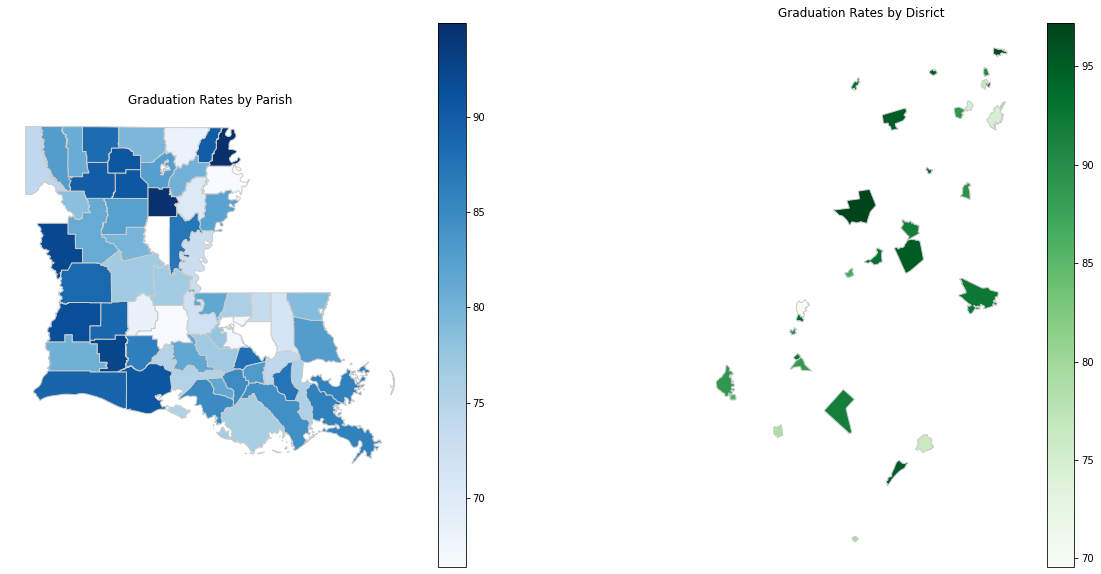

In [65]:
fig,ax = plt.subplots(1,2,figsize = (20,10))

la_coords_df.plot(column="Graduation Rate", cmap = 'Blues', linewidth=1, ax=ax[0],edgecolor = '0.8',legend=True)
nj_coords_df.plot(column="Graduation Rate", cmap = 'Greens', linewidth=1, ax=ax[1],edgecolor = '0.8',legend=True)
ax[0].set_axis_off()
ax[1].set_axis_off()

ax[0].set_title("Graduation Rates by Parish",loc="center")
ax[1].set_title("Graduation Rates by Disrict",loc="center")

plt.show()

Even though most data is missing in New Jersey and some in Louisiana (in white), with the data that is represented there does not seem to be any relation between graduation rate and location. Future exploration could focus on the search for the factors that are most influencial to a child's education.

___
## Closing Thoughts and Final Goals:

So far, little has been found in terms of correlation between funding and academic performance of school districts. The team has found this to be surprising, especially considering this was found across both data sets. While strange, this information could be used to pinpoint school districts that may be collecting a strong amount of money, only to spend it in an irresponsible way. More investigation could be further complete to detemrine why school districts with high funding amounts are underperforming in both states, and vise-versa.

As a result of the initial exploratory data analysis completed on data sets relating to financial information and academic performance of both New Jersey and Louisiana school districts, the team has deteremined new questions to consider in the future:

- **What relationships exist between variables of financial, or otherwise demographic, data and academic performance of school districts?**
    - i.e. does student/teacher ratio, diversity, or enrollment size relate to academic performance?
- **If a relationship is found, can the team predict the relative academic performances of the school districts of states, given the relevant data?**

For these questions, we are looking to test whether academic performance is dependent on other aspects of school districts. Other ways the team plans on testing for relationships is by numerically calculating $r^2$ values and other statistics that represent the strength of relationships between two variables.

It's vital that the team continues to test new attributes the school districts in search for relevant relationships. Even if none are found, however, it should be interesting to note the absence of such relationships when testing variables that are expected to relate to one another.</br> </br>

The team's next steps primarily involve three main strategies:
- **Test new financial, identity, demographic, or other attributes of each school district and compare them to academic performance**
- **Determine more methods to evaluate student performance, beyond average ACT score and 4-year graduation rate**
- **If necessary, supplement data with more states to confirm results found**

In [69]:
!jupyter nbconvert --to html Final_Tutorial.ipynb 

[NbConvertApp] Converting notebook Final_Tutorial.ipynb to html
[NbConvertApp] Writing 1374392 bytes to Final_Tutorial.html
